# Introducción
En esta práctica, se obtiene un fichero con un montón de filas con datos relacionados con puntos de interés (POI) de distintos lugares del mundo. Además, cada fila también contiene una ruta donde se encuentra la imagen cada punto de interés.
Lo que se busca es estudiar el engagement a partir de distintas características del POI, tanto de sus metadatos como de las propias imágenes.

Para ello, se calculará el engagement con una fórmula basada en los likes, dislikes y bookmarks para cada uno de los POIs y se añadirá al dataset como variable objetivo.

Además, se codificarán variables como los tags y las categories, para que puedan formar parte del modelo.

Por supuesto, se separarán los datasets en datasets de train, validación y test, y se eliminarán las variables que no sumen valor a la red neuronal que se creará.

Por último, se creará un módelo combinado, que mezclará los resultados del modelo de entrenamiento de los metadatos y de las imágenes. Para las imágenes, se usará un modelo de red neuronal preentrenado, el VGG16, mientras que para los metadatos se usará un modelo custom. Por último se entrenará el modelo y se sacarán conclusiones sobre la pérdida y la accuracy.

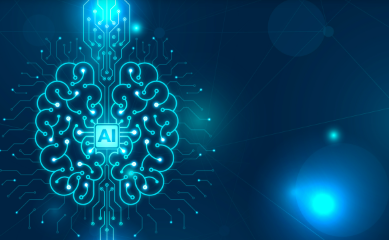

### Pre-práctica
A continuación, se monta el drive, se hacen los imports necesarios y se ejecutan las funciones del fichero model_utils.py proporcionado por el profesor.

In [ ]:
#Código para
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports necesarios para el módulo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from concurrent.futures import ThreadPoolExecutor
import io
import torchvision.models as models

In [ ]:
# Funciones de
def eval_epoch(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    avg_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

def display_loss_and_accuracy(loss_epoch_tr, loss_epoch_val, acc_epoch_tr, acc_epoch_val, test_acc, n_epochs):
    """
    Función que muestra un gráfico con dos subplots:
    - El primer subplot muestra el loss por epoch
    - El segundo subplot muestra la precisión por epoch
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(range(n_epochs), loss_epoch_tr, label='Entrenamiento')
    ax1.plot(range(n_epochs), loss_epoch_val, label='Validación')
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch #')
    ax1.set_ylabel('Loss')

    ax2.plot(range(n_epochs), acc_epoch_tr, label='Entrenamiento')
    ax2.plot(range(n_epochs), acc_epoch_val, label='Validación')
    ax2.axhline(y=test_acc, color='red', linestyle='--', label='Test')
    ax2.legend(loc='lower right')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch #')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

def display_split_pie_chart(x_train, x_val, x_test):
    """
    Función que muestra un gráfico de pie que representa la distribución
    de los conjuntos de datos (train, validation y test)
    """
    plt.figure(figsize=(10, 5))
    sizes = [x_train.shape[0], x_val.shape[0], x_test.shape[0]]
    labels = ['Train', 'Validation', 'Test']
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Distribución de los conjuntos de datos')
    plt.show()

def evaluate_model(model: nn.Module, data_loader: DataLoader, device: torch.device):
    """
    Evalúa el modelo en el conjunto de datos proporcionado y devuelve las predicciones
    y los valores reales para su posterior análisis.
    """
    print("[INFO]: Evaluando red neuronal...")
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, metadata, labels in data_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

            outputs = model(images, metadata)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    return all_predictions, all_targets

def train_epoch(model: nn.Module, device: torch.device, train_loader: DataLoader,
                criterion, optimizer, scheduler):
    """
    Entrena una época de la red neuronal y devuelve las métricas de entrenamiento.

    Args:
        model: Modelo de red neuronal a entrenar
        device: Dispositivo donde se realizará el entrenamiento (CPU/GPU)
        train_loader: DataLoader con los datos de entrenamiento
        criterion: Función de pérdida a utilizar
        optimizer: Optimizador para actualizar los pesos
        scheduler: Scheduler para ajustar el learning rate

    Returns:
        train_loss: Pérdida promedio en el conjunto de entrenamiento
        train_acc: Precisión en el conjunto de entrenamiento (%)
        current_lr: Learning rate actual después del scheduler
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, metadata, labels) in enumerate(train_loader):
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, metadata)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * correct / total

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    return train_loss, train_acc, current_lr


# Cargamos los datos
En este apartado, se van a cargar los datos del fichero csv a un dataset.

In [ ]:
# Primero configuramos el dispositivo:usaremos CUDA; si no, la CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Luego, leemos los datos del archivo CSV
data = pd.read_csv('/content/drive/MyDrive/poi_dataset.csv')
print("Datos cargados del CSV con éxito. Primeras filas:")
print(data.head())

Usando dispositivo: cuda
Datos cargados del CSV con éxito. Primeras filas:
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp...   
4  El Museo del Traje de Madrid, fundado en 2004,

El objeto data es de tipo DataFrame, que pertenece a la librería pandas.

Un DataFrame es una estructura de datos bidimensional (filas y columnas), similar a una hoja de cálculo o tabla en una base de datos, que se utiliza para manipular, analizar y procesar datos estructurados.

Conozcamos más acerca de las variables que contiene este dataframe:

In [ ]:
# Mostramos todas las columnas
print(f"Las columnas del dataset son:\n{data.columns}")

# Contamos cuántas columnas hay
print(f"Número total de columnas: {data.shape[1]}")

Las columnas del DataFrame son:
Index(['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon',
       'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes',
       'Bookmarks', 'main_image_path'],
      dtype='object')
Número total de columnas: 14


De primeras podemos saber que hay 14 variables y que no todas van a sernos útiles. Otras, sin embargo, las usaremos para crear la variable objetivo, engagement de cada POI.

# **CÁLCULO VARIABLE OBJETIVO**

A continuación, se va a calcular la columna con la variable objetivo para cada POI.
Puesto que el target o variable objetivo en este caso es el engagement de cada POI, primero se va a calcular para cada fila, el engagement score. Este valor se va a obtener a partir de los números de likes, bookmarks y dislikes.
En este caso, la fórmula que utilizamos para calcular el engagement score combina tres variables que existen ya en el fichero csv:

*  **Likes**: Representan interacciones positivas con el contenido.
*  **Bookmarks**: Indican que los usuarios están interesados en guardar el contenido para revisarlo más tarde, lo cual también es una señal positiva.
*  **Dislikes**: Representan interacciones negativas que restan del compromiso general.

A estas variables les vamos a dar un peso para reflejar su importancia relativa en el cálculo del engagement score. Los pesos que he determinado son los siguientes:

*   **alpha** (peso de los Likes) = 0.5, ya que considero que los Likes son la métrica más importante.
*   **beta** (peso de los Bookmarks) = 0.3, porque los Bookmarks también son relevantes, pero un poco menos que los Likes.
*   **gamma** (peso de los Dislikes) = 0.2, ya que los Dislikes tienen un impacto negativo, pero no tan fuerte como las interacciones positivas.

La fórmula resultante para el cálculo del engagement entonces sería la siguiente:

engagement_score=alpha × Likes+ beta × Bookmarks − gamma × Dislikes

In [ ]:
# Se calcula el score de engagement de cada POI
def calculate_engagement_score(row):
    alpha, beta, gamma = 0.5, 0.3, 0.2
    return alpha * row['Likes'] + beta * row['Bookmarks'] - gamma * row['Dislikes']

data['engagement_score'] = data.apply(calculate_engagement_score, axis=1)

#Resultado:
print("Resultado de las primeras 10 filas")
data[['engagement_score']].head(10)

Resultado de las primeras 10 filas


,engagement_score
0,-482.0
1,4688.1
2,1580.7
3,4971.1
4,-78.8
5,4925.2
6,1553.3
7,1538.3
8,4917.7
9,-149.7


Una vez tenemos calculado los engagement scores, vamos a calcular el engagement en sí, clasificando los datos en tres niveles (bajo, neutro y alto) usando los percentiles del engagement score.

0 será bajo, 1 neuro y 2 alto.

In [ ]:
# Se calculan los percentiles.
low_threshold = data['engagement_score'].quantile(1/3)  # Umbral para "Bajo"
high_threshold = data['engagement_score'].quantile(2/3) # Umbral para "Alto"

# Se crea una función, que añade el valor número de 0 a 2 indicando el engagement
# basándose en los terciles ya calculados.
def classify_engagement(row):
    if row['engagement_score'] < low_threshold:
        return 0  # Bajo
    elif row['engagement_score'] < high_threshold:
        return 1  # Neutro
    else:
        return 2  # Alto

data['engagement'] = data.apply(classify_engagement, axis=1)

print(f"Sumatorio de valores por cada engamenet: {data['engagement'].value_counts()}")

print(f"\nResultado de las columnas engagement y engagement_score:\n {data[['engagement', 'engagement_score']].head(20)}")

Sumatorio de valores por cada engamenet: engagement
0    523
2    523
1    522
Name: count, dtype: int64

Resultado de las columnas engagement y engagement_score:
     engagement  engagement_score
0            0            -482.0
1            2            4688.1
2            2            1580.7
3            2            4971.1
4            1             -78.8
5            2            4925.2
6            2            1553.3
7            2            1538.3
8            2            4917.7
9            1            -149.7
10           2           12072.7
11           2            5178.4
12           0            -503.3
13           2            4797.3
14           1            -164.3
15           1             -91.8
16           0            -557.4
17           0            -515.5
18           0            -383.8
19           1            -224.8


# **Codificación de variables**
La codificación de variables se suele realizar tras el split de los datasets en train, test y validación. Sin embargo, en este caso, puesto que la codificación de las variables categories y tags van a crear columnas nuevas, no es posible codificar después del split porque se podría dar el caso de que en cada dataset se creara un número de columnas distintas. Sin embargo, necesitamos que los datasets de train, validación y test para los metadatos, tengan la misma dimensión que indica el número de variables.

Bajo mi parecer, se ha complicado un poco la codificación de las variables Tags y categories porque son listados muy largos y muy distintos para cada fila del fichero inicia. Hay muchísimos posibles valores en las listas.

* Codificación variable categories.
Para codificar la variable categories, primero convertimos las cadenas de texto de la columna en listas. Luego se eliminan las filas donde la lista esté vacía, ya que no tienen información útil. Para codificar, usamos MultiLabelBinarizer para transformar las listas de categorías en columnas binarias, donde cada columna representa una categoría. Si una fila contiene esa categoría, ponemos un 1; si no, un 0.
Integramos estas columnas binarias al dataset y eliminamos la columna original de categories.

*  Codificación variable tags.
Convertimos las cadenas de texto de la columna tags en listas reales (de objetos, no solo texto). Se usa ast.literal_eval para esto.
Además, se eliminan las filas donde tags sea una lista vacía. Puesto que hay un montón de posibles valores en las listas de tags, vamos a descartar aquellos valores que aparecen menos de 3 veces, es decir, nos quedamos con las más comunes. POr ello, filtramos los valores de las listas de tags, manteniendo únicamente las etiquetas comunes.
Por último, eliminamos las filas que queden vacías después de este filtrado y codificamos tags usando MultiLabelBinarizer: Igual que con categories, transformamos las listas de etiquetas en columnas binarias, donde cada columna representa una etiqueta.
Integramos estas columnas binarias al dataset y se elimina la columna original de tags.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# ------CODIFICACIÓN VARIABLE CATEGORIES----
# Se convierte la columna 'categories' de cadenas de texto a listas y se eliminan filas vacías
data['categories'] = data['categories'].astype(str).str.strip('[]').str.replace("'", '').str.split(', ')
data = data[data['categories'].apply(lambda x: len(x) > 0)]  # Se filtran las filas con listas vacías en 'categories'

# Se codifica la columna 'categories' en formato binario utilizando MultiLabelBinarizer
mlb_categories = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb_categories.fit_transform(data['categories']),
    columns=mlb_categories.classes_,
    index=data.index
)

# Se integra la codificación binaria al dataset y se elimina la columna original 'categories'
data = pd.concat([data.drop(columns=['categories']), categories_encoded], axis=1)

# -----CODIFICACIÓN VARIABLE TAGS------
# Se convierte la columna 'tags' de cadenas de texto a listas reales y se eliminan filas vacías
data['tags'] = data['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data = data[data['tags'].apply(lambda x: len(x) > 0)]  # Se filtran las filas con listas vacías en 'tags'

# Se calculan las etiquetas comunes (aquellas que aparecen al menos 3 veces)
tag_counts = pd.Series([tag for sublist in data['tags'] for tag in sublist]).value_counts()
common_tags = tag_counts[tag_counts >= 3].index.tolist()

# Se mantienen solo las etiquetas comunes en las listas de 'tags' y se eliminan filas vacías resultantes
data['tags'] = data['tags'].apply(lambda x: [tag for tag in x if tag in common_tags])
data = data[data['tags'].apply(lambda x: len(x) > 0)]  # Se filtran filas con listas vacías en 'tags' tras el filtrado

# Se codifica la columna 'tags' en formato binario utilizando MultiLabelBinarizer
mlb_tags = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(
    mlb_tags.fit_transform(data['tags']),
    columns=mlb_tags.classes_,
    index=data.index
)

# Se integra la codificación binaria al dataset y se elimina la columna original 'tags'
data = pd.concat([data.drop(columns=['tags']), tags_encoded], axis=1)

# Se muestra el dataset procesado
print("\nDataset procesado:\n", data.head())
print(f"Dimensiones finales del dataset: {data.shape}")


Dataset procesado:
                                       id  \
30  8a3b45ac-d2bc-4e97-8101-d5af4b40613c   
41  791798a0-f9a8-43de-963d-6b8a5fb18382   
46  2ab0d4c0-b264-4bfe-bdee-2e380cd3fe91   
52  ada425ce-fa30-4d62-abf1-ea968232fea9   
54  77d02f80-bee7-474e-8359-66b5096ee625   

                                                 name  \
30                             Hamburguesería Don Oso   
41  "El Gran Canal desde San Vio, Venecia",  hacia...   
46              "Metrópolis", 1916-1917, George Grosz   
52  "Quappi con suéter rosa", 1932 - 1934, Max Bec...   
54  "Retrato de George Dyer en un espejo", 1968, F...   

                                     shortDescription  tier  locationLon  \
30  Don Oso, inaugurada en 1973, es un emblema mad...     3    -3.716334   
41  “El Gran Canal desde San Vio” es una obra maes...     1    -3.694821   
46  "Metrópolis" de George Grosz, una obra impacta...     1    -3.695119   
52  "Quappi con jersey rosa" de Max Beckmann es un...     1    -3.6

<ipython-input-8-0df326f9e35d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tags'] = data['tags'].apply(lambda x: [tag for tag in x if tag in common_tags])


Vemos que aparecen muchas filas en el dataset, habiendo un total de 626 filas en total.

# **TRATAMIENTO DE IMÁGENES**
En el fichero csv la columna **main_image_path** indica la ruta relativa de donde se encuentra cada imagen del POI de cada fila.
Vamos primero a calcular las dimensiones de las imágenes, escogemos una al azar y la analizamos:






In [ ]:
# Ruta a la carpeta principal
data_main_path = "/content/drive/MyDrive/data_main/data_main/002b3c1f-37f0-4d36-84d4-2d7132f83fe7/main.jpg"
# Abrimos la imagen y obtenemos sus dimensiones
with Image.open(data_main_path) as image:
    width, height = image.size
    print(f"Las dimensiones de la imagen son: {width}x{height}")

Las dimensiones de la imagen son: 128x128


A continuación, lo que se va a hacer es recuperar cada imagen y con la función **load_and_process_image** se va a procesar cada una de ellas. Para ello, se van a abrir, a convertir en RGB (ya que son a color) y en numpy array y se normaliza.


In [ ]:
base_path = "/content/drive/MyDrive/data_main"

def load_and_process_image(image_path):
    full_path = os.path.join(base_path, image_path)  # Combinamos la ruta base con el nombre del archivo.
    try:
        img = Image.open(full_path).convert('RGB')  # Abrimos la imagen y la convertimos al formato RGB.
        return np.array(img, dtype=np.float32) / 255.0  # Convertimos la imagen a un array NumPy y la normalizamos.
    except Exception as e:
        print(f"No se pudo cargar la imagen: {full_path}. Error: {e}")  # Si algo falla, imprimimos un mensaje con el error.
        return None  # Retornamos `None` si no se pudo cargar.


Además, para ejecutar esta función por cada una de las imágenes, se va a hacer uso del paralelismo. Con el uso de los hilos, se pueden cargar varias imagenes a la vez de forma paralela, lo que agiliza un montón este paso. Sin paralelismo podía tardar minutos, y con él, unos pocos segundos. A continuación, se explica un poco el proceso de carga de las imágenes:

*  Con ThreadPoolExecutor: Creamos un "grupo" de 8 hilos (max_workers=8), que son como trabajadores que pueden ejecutar tareas al mismo tiempo. Esto permite que muchas imágenes se carguen y procesen a la vez, en lugar de hacerlo una por una.

*  COn executor.map asignamos a cada hilo la tarea de llamar a load_and_process_image con las rutas de las imágenes que tenemos en data['main_image_path']. Esto genera una lista (image_arrays) donde cada elemento es el resultado de procesar una imagen (o None si hubo un error).

In [ ]:
# Ejecutamos en paralelo load_and_process_image para cada imagen
with ThreadPoolExecutor(max_workers=8) as executor:
    image_arrays = list(executor.map(load_and_process_image, data['main_image_path']))

# Filtramos las imágenes inválidas y las descartamos, quedándonos solo con las filas válidas
valid_indices = [i for i, img in enumerate(image_arrays) if img is not None]
image_arrays = [image_arrays[i] for i in valid_indices]
data = data.iloc[valid_indices]

# Convertimos a numpy array para ver el tamaño de cada una:
images_dataset = np.array(image_arrays, dtype=np.float32)
print(f"Shape del dataset de imágenes: {images_dataset.shape}")

No se pudo cargar la imagen: /content/drive/MyDrive/data_main/data_main/ffa33c34-9ac3-4ff2-b9ea-a3af828cf0a2/main.jpg. Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/data_main/data_main/ffa33c34-9ac3-4ff2-b9ea-a3af828cf0a2/main.jpg'
No se pudo cargar la imagen: /content/drive/MyDrive/data_main/data_main/ff8bdc36-0a86-496e-afdd-1ccb3fe698e8/main.jpg. Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/data_main/data_main/ff8bdc36-0a86-496e-afdd-1ccb3fe698e8/main.jpg'
No se pudo cargar la imagen: /content/drive/MyDrive/data_main/data_main/ffa5b2e8-30fb-41d7-b0fa-aaa7d8815baf/main.jpg. Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/data_main/data_main/ffa5b2e8-30fb-41d7-b0fa-aaa7d8815baf/main.jpg'
No se pudo cargar la imagen: /content/drive/MyDrive/data_main/data_main/ffd48a7d-f1f7-425c-9c52-fa534cc82167/main.jpg. Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/data_main/data_main/ffd48a7d-f1f7-425c-9c52-fa534cc

El resultado es que tenemos un data set de 1568 filas donde por cada fila hay imagen cnvertida en un array de 128x128x3, ya que cada imagen tiene unas dimensiones de 128x128 y 3 canales de color al estar en formato RGB (red, green y blue).

# **DIVISIÓN DEL DATASET EN TRAIN, VALIDACIÓN Y TEST**

En esta sección se va a hacer la división de los datasets de Train, Validation y Test.
Para ello, se va a utilizar la función train_test_split primero para calcular el dataset de train, con el 70 % de los datos, y luego, el 15 % para test y 15 % para validación.

Puesto que, una vez que hagamos el split, no hay forma de relacionar cada fila de metadatos con su imagen, he pensado un approach distinto. Lo que se va a hacer es hacer el split pero guardando los índices de cada fila, para poder hacer esta relación entre metadata ysu foto.

Por ello, en el siguiente código, primero, se agrega una nueva columna al dataset que indica el orden de cada fila.
Después, se hace el split usando la función **train_test_split** y guardando el conjunto de índices de las filas que se guardan en train. Lo mismo para el segundo split.
De esta forma, el orden de filas en los sets de train, test y validación para los metadatos, coincidirá con el orden de filas en los datasets de imágenes de train, test y validación respectivamente.

Por ejemplo, si el POI XX, está en la fila 15 del dataset de train de metadatos, estará en la fila 15 del dataset de imágenes de train, pudiendo mantener la relación entre medatados e imagen para el POI.


In [ ]:
# Aseguramos que los índices originales del DataFrame se mantengan antes del split
data = data.reset_index(drop=False)  # Agregar una columna con los índices originales

data.head()

,index,id,name,shortDescription,tier,locationLon,locationLat,xps,Visits,Likes,...,Yacimientos,Zarzuela,Zodiaco,brujas,castizo,s.XX,tapas,teatro,volcán,Águilas
0,30,8a3b45ac-d2bc-4e97-8101-d5af4b40613c,Hamburguesería Don Oso,"Don Oso, inaugurada en 1973, es un emblema mad...",3,-3.716334,40.436622,100,10008,635,...,0,0,0,0,0,1,0,0,0,0
1,41,791798a0-f9a8-43de-963d-6b8a5fb18382,"""El Gran Canal desde San Vio, Venecia"", hacia...",“El Gran Canal desde San Vio” es una obra maes...,1,-3.694821,40.416056,500,10009,8124,...,0,0,0,0,0,0,0,0,0,0
2,46,2ab0d4c0-b264-4bfe-bdee-2e380cd3fe91,"""Metrópolis"", 1916-1917, George Grosz","""Metrópolis"" de George Grosz, una obra impacta...",1,-3.695119,40.416275,500,10018,2478,...,0,0,0,0,0,1,0,0,0,0
3,52,ada425ce-fa30-4d62-abf1-ea968232fea9,"""Quappi con suéter rosa"", 1932 - 1934, Max Bec...","""Quappi con jersey rosa"" de Max Beckmann es un...",1,-3.694825,40.416031,500,10011,2727,...,0,0,0,0,0,1,0,0,0,0
4,54,77d02f80-bee7-474e-8359-66b5096ee625,"""Retrato de George Dyer en un espejo"", 1968, F...","""Retrato de George Dyer en un espejo"" de Franc...",1,-3.694786,40.416136,500,10011,8465,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Dimensiones de data y images_dataset
print(f"Dimensiones de 'data': {data.shape}")
print(f"Dimensiones de 'images_dataset': {images_dataset.shape}")

Dimensiones de 'data': (1399, 627)
Dimensiones de 'images_dataset': (1399, 128, 128, 3)


División de los conjuntos de metadatos:



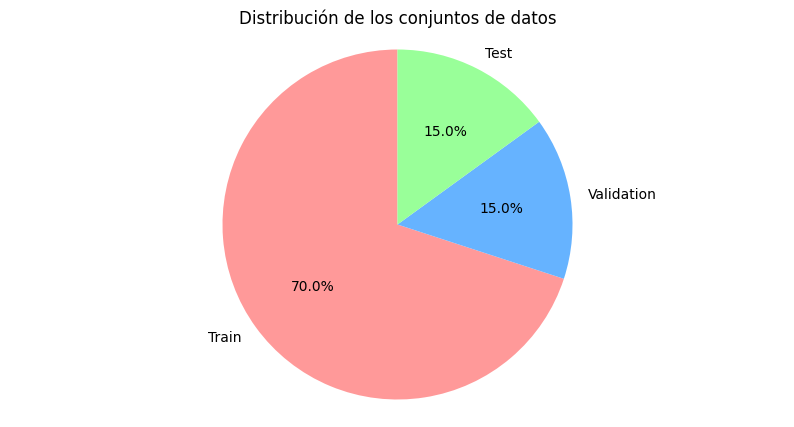

División de los conjuntos de imágenes:



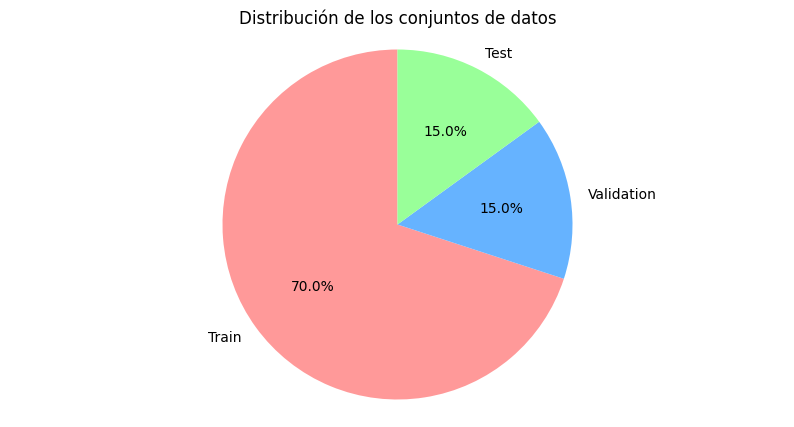

In [ ]:
# Primero se divide en train y un conjunto temporal (usando índices)
train_data, temp_data, train_indices, temp_indices = train_test_split(
    data, data.index, test_size=0.3, random_state=42, stratify=data['engagement']
)

# Después se divide el conjunto temporal en validación y test
val_data, test_data, val_indices, test_indices = train_test_split(
    temp_data, temp_indices, test_size=0.5, random_state=42, stratify=temp_data['engagement']
)

# Ahora se usan estos índices para extraer imágenes correspondientes a cada split
train_images = images_dataset[train_indices]
val_images = images_dataset[val_indices]
test_images = images_dataset[test_indices]

# Se extraen también las variables objetivo.
train_labels = train_data['engagement']
val_labels = val_data['engagement']
test_labels = test_data['engagement']

# Por último, visualizamos esta división en conjuntos para
print("División de los conjuntos de metadatos:\n")
display_split_pie_chart(train_data, val_data, test_data)
print("División de los conjuntos de imágenes:\n")
display_split_pie_chart(train_images, val_images, test_images)

In [ ]:
# Vemos que coincide perfectamente el tamaño de los conjuntos para train, val y test de metadatos e imágenes
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")
print(f"Train size: {len(train_images)}, Validation size: {len(val_images)}, Test size: {len(test_images)}")

Train size: 979, Validation size: 210, Test size: 210
Train size: 979, Validation size: 210, Test size: 210


# **Eliminación de variables**
Es importante eliminar aquellas variables que dejan de ser útiles para entrenar el modelo.
En este caso, eliminamos la lista de variables que han formado parte del cálculo de la variable objetivo, engagement. Y después borramos aquellas que no aportan valor, como son el id, name, shortDescription, tier, locationLon, locationLat, xps y main_image_path.
Primero se borran del dataset de train, y después del de validación y test.

In [ ]:
# Listados de variables a borrar:
columns_to_drop1 = ['Likes', 'Dislikes', 'Bookmarks', 'engagement_score', 'index'] #Columnas usadas para calcular el engagement + index, que se usó para crear los datasets.
columns_to_drop2 = ['id', 'name', 'shortDescription', 'locationLon', 'locationLat', 'xps','main_image_path'] #Columnas no útiles para entrenar el modelo.

# Se eliminan columnas innecesarias
train_data = train_data.drop(columns=columns_to_drop1 + columns_to_drop2)

print(f"Tamaño train_data: {train_data.shape}")



Tamaño train_data: (979, 615)


In [ ]:
train_data.head()

,tier,Visits,engagement,,Arquitectura,Ciencia,Cine,Cultura,Escultura,Gastronomía,...,Yacimientos,Zarzuela,Zodiaco,brujas,castizo,s.XX,tapas,teatro,volcán,Águilas
1282,1,10012,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
262,2,10010,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
448,2,10006,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
290,2,10012,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,2,10016,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


# **Aplicamos a val y test**

In [ ]:
# Se eliminan las columnas innecesarias para los datasets de validacion y test
val_data = val_data.drop(columns=columns_to_drop1 + columns_to_drop2)
test_data = test_data.drop(columns=columns_to_drop1 + columns_to_drop2)

print(f"val_data: {val_data.shape}")
print(f"test_data: {test_data.shape}")


val_data: (210, 615)
test_data: (210, 615)


# **Creación de datasets.**




## Cálculo media y desviación estándar


 Calculamos la media y la desviación estándar de las imágenes del conjunto de entrenamiento (train_images).
Esto nos ayuda a normalizar las imágenes, es decir, ajustar sus valores para que tengan una distribución uniforme, lo cual mejora el rendimiento del modelo.

In [ ]:
# Se calcula la media y desviación estándar de las imágenes para las transformaciones de las mismas
mean = np.mean(train_images, axis=(0, 1, 2))
std = np.std(train_images, axis=(0, 1, 2))
print(f"Media: {mean}, Desviación estándar: {std}")

Media: [0.4459101  0.445518   0.42147848], Desviación estándar: [0.26066288 0.25896394 0.26936397]


## Transformaciones de imágenes
A continuación se definen una serie de transformaciones  necesarias que se aplicarán a las imágenes antes de pasarlas al modelo.
Estas transformaciones sirven para aumentar artificialmente los datos y preparar las imágenes para el modelo.

*  **RandomHorizontalFlip**: Volteamos las imágenes horizontalmente al azar (50% de probabilidad).
*  **RandomRotation**: Rotamos las imágenes hasta 10 grados.
*  **ColorJitter**: Alteramos ligeramente el brillo y el contraste para hacer el modelo más robusto.
*  **Resize**: Ajustamos las imágenes al tamaño que el modelo espera. EN este caso, se usará el modelo VGG16, que requiere imágenes de 224x224 píxeles.
*  **ToTensor**: Convertimos las imágenes a tensores para que PyTorch las entienda.
*  **Normalize**: Usamos la media y la desviación estándar calculadas para normalizar las imágenes.

En el siguiente código se aplican las transformaciones y se guardan en la variable transform.

In [ ]:
# Transformaciones para imágenes
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),  # Normalización calculada
])


# Definición de los Point of Interesting Datasets

A continuación, se va a crear una clase llamada POIDataset para manejar nuestro conjunto de datos. Esto es importante porque PyTorch necesita una estructura específica para trabajar con datos, y esta clase nos ayuda a organizar tanto las imágenes como los metadatos y las etiquetas. Esta clase contiene:

*  __init__: Inicializamos el dataset con las imágenes, los datos y las etiquetas, además de las transformaciones opcionales.
*  __len__: Le decimos a PyTorch cuántos datos tenemos.
*  __getitem__: Preparamos los datos en un formato listo para usar.
  *  Convertimos las imágenes en tensores (y les aplicamos las transformaciones).
  *  Extraemos los metadatos de cada fila del dataframe. Para ello, cogemos todas las variables del dataset y excluimos la variable target, ya que ya se han eliminado todas las variables que no forman parte del modelo.
  *  Convertimos las etiquetas o target a tensores.

In [ ]:
# Dataset personalizado
class POIDataset(Dataset):
    def __init__(self, data, image_arrays, labels, transform=None):
        self.data = data
        self.image_arrays = image_arrays
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convertimos las imágenes, metadatos y target en tensores
        image = self.image_arrays[idx]
        metadata = self.data.iloc[idx][[col for col in self.data.columns if col != 'engagement']].values.astype(np.float32)
        label = self.labels.iloc[idx]

        # Aplicamos las transformaciones a la imagen si existen
        if self.transform:
            image = self.transform(Image.fromarray((image * 255).astype(np.uint8)))

        # Aseguramos que los datos sean tensores
        image = torch.tensor(image, dtype=torch.float32) if not torch.is_tensor(image) else image
        metadata = torch.tensor(metadata, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, metadata, label

# Por último, creamos los datasets de train, val y test, haciendo uso de la clase definida.
train_dataset = POIDataset(train_data, train_images, train_labels, transform=transform)
val_dataset = POIDataset(val_data, val_images, val_labels, transform=transform)
test_dataset = POIDataset(test_data, test_images, test_labels, transform=transform)

## Creación de dataloaders
El siguiente código tiene como objetivo crear dataloaders para manejar los datasets de entrenamiento, validación y prueba durante el proceso de entrenamiento de un modelo. Los dataloaders dividen los datos en lotes (batches) y gestionan cómo se cargan en cada iteración.

Para el tamaño de lote o batch size, vamos a escoger 32, lo que significa que los datos se procesan en grupos de 32 muestras cada vez. Esto optimiza el uso de memoria y acelera los cálculos.

*  Dataloader de entrenamiento (train_loader):
Este dataloader carga los datos de entrenamiento (train_dataset) en lotes de tamaño batch_size. En este caso, he puesto shuffle a false, porque no quiero que desordene los datos, ya que necesitan permanecer en orden para mantener la relación con las imágenes con los metadatos.
*  Dataloader de validación (val_loader):
Este dataloader gestiona el conjunto de validación (val_dataset), que se usa para evaluar el rendimiento del modelo después de cada época de entrenamiento.
*  Dataloader de prueba (test_loader):
Similar al de validación, este dataloader carga los datos de prueba (test_dataset) sin desordenarlos (shuffle=False).

In [ ]:

# Crear dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Creación de modelos.

### Modelo para imágenes

Para el modelo de las imágenes, se va a definir una clase llamada ImageModel.
Esta clase define el modelo, que va a ser el VGG16, que es un modelo pre entrenado.
*  En el constructor __init__, cargamos el modelo VGG16 y reemplazamos la última capa de clasificación para que tenga 128 salidas en lugar de 1000. Reducir la salida a 128 hace que las características sean más compactas y manejables, lo que facilita la combinación posterior con los metadatos.
*  En el método **forward**, simplemente pasamos las imágenes a través del modelo.

In [ ]:
# Modelos para imágenes
class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg16(pretrained=True)  # Utilizamos VGG16 preentrenado
        self.model.classifier[6] = nn.Linear(4096, 128)  # Cambiamos la última capa para que tenga 128 salidas

    def forward(self, x):
        return self.model(x)  # Pasamos las imágenes a través del modelo

# Revisamos el tamaño de los metadatos
metadata_dim = train_data.shape[1]  # Número de columnas en los metadatos (sin la etiqueta)
print(f"Tamaño de los metadatos: {metadata_dim}")

Tamaño de los metadatos: 615


### Modelo para los metadatos
Para los metadatos, se va a crear un modelo definido en la clase MetadataModel.
*  En el constructor __init__, definimos una secuencia de capas (entrada -> ReLU -> salida). La dimensión de entrada es el número de características en los metadatos, y la salida tiene 128 neuronas.
Componentes principales del modelo
  *  Capa de entrada (Linear(input_dim, 64))
La primera capa toma input_dim características como entrada. Este número es la cantidad de columnas que tienen los metadatos.
Luego, reduce esas características a 64 neuronas. Esta reducción ayuda a extraer patrones más compactos o combinaciones de las características de entrada.
La salida de esta capa es un vector de 64 valores.
  * ReLU (nn.ReLU()).
ReLU (Rectified Linear Unit) es una función de activación que se aplica después de la primera capa. Si un valor es negativo, lo convierte en 0; si es positivo, lo deja como está.
  ReLU introduce no linealidad en el modelo, lo cual es crucial para que la red neuronal pueda aprender relaciones complejas entre las características de entrada.
  * Capa oculta y de salida (Linear(64, output_dim))
  La segunda capa toma las 64 características procesadas y las reduce a un número aún más compacto: 128 características (output_dim=128).
  Esta salida representa un vector con la información más relevante de los metadatos, listo para combinarse con las características del modelo de imágenes.

*  En el método forward, pasamos los metadatos a través de estas capas.

In [ ]:

# Modelo de metadatos
class MetadataModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),  # Capa de entrada con dimensión de los metadatos
            nn.ReLU(),  # Activación ReLU
            nn.Linear(64, output_dim)  # Capa de salida con 128 neuronas
        )

    def forward(self, x):
        return self.layers(x)  # Pasamos los metadatos a través de las capas


### Modelo combinado
Para combinar el modelo de las imgánes y los medatados, se ha creado un método que utiliza ambos para hacer als predicciones teniendo todo en cuenta.
Para ello, primero procesa las imágenes con el modelo preentrenado VGG16 para extraer las características de las imágenes. EL modelo observa la simágenes y extrae patrones de ellas.Después, procesa los metadatos yextrayendo también información de cada POI. A continuación, combina las características extraídas de las imágenes y metadatos en un solo conjunto de características combinaod.Por último, hace la predicción. En este caso, predice el tipo de engagement entre bajo, neutro o algo.
Por ello, para cada fila del dataset, se estudia sus características, los metadatos y se combinan ambos.

Esto se aplica en el siguiente código, donde se crea una clase que hace todo lo mencionado. En esta clase encontramos:
*  En el constructor __init__, recibimos los modelos de imágenes y metadatos, y definimos una red fully connected (fc) que toma las características combinadas de ambos modelos. Como se puede ver, la red recibe 128 características extraídas de las imágenes y 128 características generadas por el modelo de metadatos. La idea es que ambos conjuntos de características (de imágenes y metadatos) tengan la misma dimensión para que puedan combinarse de manera eficiente.
*  En el método forward, pasamos las imágenes y los metadatos por sus respectivos modelos, los concatenamos y pasamos la combinación a través de la red completamente conectada.

In [ ]:
# Modelo combinado
class CombinedModel(nn.Module):
    def __init__(self, image_model, metadata_model):
        super().__init__()
        self.image_model = image_model
        self.metadata_model = metadata_model

        # La salida combinada será img_features_dim + meta_features_dim
        self.fc = nn.Sequential(
            nn.Linear(128 + 128, 256),  #128 características de metadatos + 128 características de las imágenes
            nn.ReLU(),
            nn.Dropout(0.3),  # Regularización
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,3)  # 3 clases de salida: engagement alto, bajo o neutro
        )

    def forward(self, image, metadata):
        img_features = self.image_model(image)
        meta_features = self.metadata_model(metadata)
        combined = torch.cat((img_features, meta_features), dim=1) #Concatenamos las características de las imágenes y los metadatos a lo largo de la dimensión 1.
        return self.fc(combined) #Pasamos la combinación de características a través de la secuencia de capas completamente conectadas para obtener la predicción final.

A continuación, se crean los modelos usando las clases recién explicadas.

In [ ]:
# Creamos los modelos
image_model = ImageModel().to(device)
metadata_model = MetadataModel(input_dim=636, output_dim=128).to(device)  # el input es la dimension de salida de image_model
combined_model = CombinedModel(image_model, metadata_model).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 25

# Entrenamiento
A continuación, se entrena el modelo.

Con el siguiente código se entrena y valida un modelo en un ciclo de varias épocas o epochs (en este caso, 25 epochs). Es la parte principal del flujo de entrenamiento de modelos en PyTorch. Lo que hacemos en cada época es:

*  Se entrena el modelo ajustando los pesos del modelo usando los datos de entrenamiento.
*  Se valida el modelo evaluando el rendimiento del modelo en el conjunto de validación para asegurarnos de que no está sobreajustando.
*  Se registran las métricas como son las pérdidas (loss) y las precisiones (accuracy) en listas para analizarlas después del entrenamiento.

### Descripción del siguiente código
Primero se crean cuatro listas vacías para registrar las pérdidas y las precisiones tanto de entrenamiento como de validación de cada epoch.
Recorremos un bucle que itera tantas veces como epochs definidos.
Dentro del bucle, en cada epoch:
*  Entrenamos el modelo usando la función train_epoch.
*  Calculamos las métricas de pérdida y precisión en el conjunto de entrenamiento, y también actualizamos la tasa de aprendizaje (si hay programador de aprendizaje, como scheduler).
*  Validamos el modelo usando la función eval_epoch para obtener las métricas en el conjunto de validación.
*  Imprimimos las métricas de entrenamiento y validación para monitorizar el progreso del modelo.

In [ ]:
# Listas para registrar las métricas de cada época
train_losses, train_accs, val_losses, val_accs = [], [], [], []

# Bucle principal: Entrenamos el modelo por un número fijo de épocas
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")  # Indicamos en qué época estamos

    # **Entrenamiento**: Aquí actualizamos los pesos del modelo con el conjunto de entrenamiento
    epoch_train_loss, epoch_train_acc, current_lr = train_epoch(
        model=combined_model,         # Modelo combinado de imágenes y metadatos
        device=device,                # Dispositivo (CPU/GPU)
        train_loader=train_loader,    # Dataloader del conjunto de entrenamiento
        criterion=criterion,          # Función de pérdida (CrossEntropyLoss)
        optimizer=optimizer,          # Optimizador (Adam en este caso)
        scheduler=scheduler           # Scheduler para ajustar la tasa de aprendizaje
    )
    # Guardamos las métricas de entrenamiento en las listas
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Imprimimos las métricas de entrenamiento
    print(f"[Train] Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%, LR: {current_lr:.6f}")

    # **Validación**: Aquí evaluamos el modelo en el conjunto de validación
    epoch_val_loss, epoch_val_acc = eval_epoch(
        model=combined_model,         # Modelo combinado
        device=device,                # Dispositivo (CPU/GPU)
        val_loader=val_loader,        # Dataloader del conjunto de validación
        criterion=criterion           # Función de pérdida (CrossEntropyLoss)
    )
    # Guardamos las métricas de validación en las listas
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # Imprimimos las métricas de validación
    print(f"[Validation] Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

Epoch 1/25
[Train] Loss: 4.5809, Acc: 38.20%, LR: 0.000100
[Validation] Loss: 1.0284, Acc: 48.57%
Epoch 2/25
[Train] Loss: 1.8596, Acc: 41.88%, LR: 0.000100
[Validation] Loss: 0.9773, Acc: 55.24%
Epoch 3/25
[Train] Loss: 1.3050, Acc: 45.35%, LR: 0.000100
[Validation] Loss: 0.9703, Acc: 44.76%
Epoch 4/25
[Train] Loss: 1.1046, Acc: 47.50%, LR: 0.000100
[Validation] Loss: 0.9141, Acc: 58.57%
Epoch 5/25
[Train] Loss: 0.9263, Acc: 56.79%, LR: 0.000010
[Validation] Loss: 0.8346, Acc: 61.90%
Epoch 6/25
[Train] Loss: 0.8292, Acc: 59.86%, LR: 0.000010
[Validation] Loss: 0.8359, Acc: 61.90%
Epoch 7/25
[Train] Loss: 0.8082, Acc: 61.90%, LR: 0.000010
[Validation] Loss: 0.8368, Acc: 58.57%
Epoch 8/25
[Train] Loss: 0.7822, Acc: 63.53%, LR: 0.000010
[Validation] Loss: 0.8485, Acc: 58.10%
Epoch 9/25
[Train] Loss: 0.7795, Acc: 63.13%, LR: 0.000010
[Validation] Loss: 0.8545, Acc: 62.38%
Epoch 10/25
[Train] Loss: 0.7382, Acc: 66.09%, LR: 0.000001
[Validation] Loss: 0.8542, Acc: 61.43%
Epoch 11/25
[Train]

## Evaluación en test

A continuación, se evalúa el modelo en el dataset de test y se estudia el accuracy con este modelo.

In [ ]:
# Evaluación en test
predictions, true_labels = evaluate_model(combined_model, test_loader, device)
test_acc = 100 * sum([p == t for p, t in zip(predictions, true_labels)]) / len(true_labels)
print(f"Accuracy en test: {test_acc:.2f}%")

[INFO]: Evaluando red neuronal...
Accuracy en test: 66.67%


## Se grafican las métricas

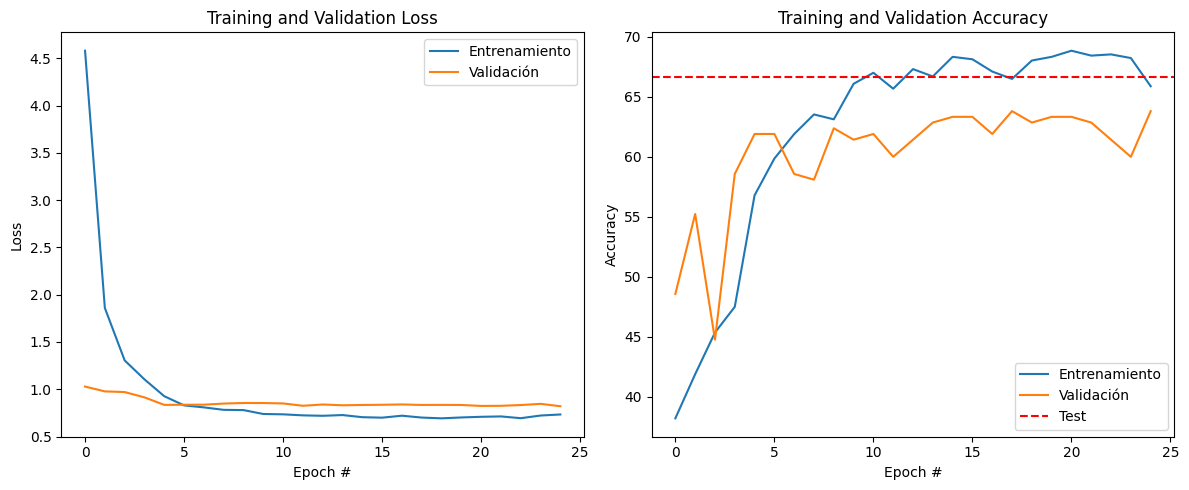

In [ ]:
# Graficamos las métricas
display_loss_and_accuracy(
    loss_epoch_tr=train_losses,
    loss_epoch_val=val_losses,
    acc_epoch_tr=train_accs,
    acc_epoch_val=val_accs,
    test_acc=test_acc,
    n_epochs=epochs
)

# Conclusiones

Después de revisar los resultados del entrenamiento y la validación, así como los gráficos generados, voy a sacar varias conclusiones sobre el rendimiento del modelo y su comportamiento.
Mis conclusiones son las siguientes:

* **Pérdida y Precisión durante el entrenamiento**
En el gráfico de pérdida (Training and Validation Loss), se observa una disminución pronunciada de la pérdida tanto para el entrenamiento como para la validación en las primeras épocas. Esto indica que el modelo está aprendiendo rápidamente al principio, lo cual es normal porque los pesos iniciales están alejados del óptimo.
A partir de la época 10, la curva de pérdida de validación se estabiliza, lo que sugiere que el modelo ya no mejora significativamente su rendimiento en el conjunto de validación. Se podría haber reducido el número de épocas, por ejemplo a 15, para evitar que hubiera un sobreajuste.
Además, la pérdida de entrenamiento es consistentemente más baja que la de validación, lo que puede ser señal de un ligero sobreajuste.

* **Precisión durante el entrenamiento**.
En el gráfico de precisión (Training and Validation Accuracy), noto que la precisión de entrenamiento aumenta rápidamente al inicio y alcanza un punto de saturación alrededor de la época 10.
La precisión de validación también sigue un patrón similar, alcanzando un pico al final. Sin embargo, hay cierta variabilidad en la curva de validación, lo cual podría deberse a la cantidad de datos o a una sensibilidad del modelo a los lotes de validación.
El modelo logra una precisión en validación que es comparable a la de entrenamiento, lo cual indica que no hay un problema significativo de sobreajuste o bajoajuste.

* **Observación del desempeño del modelo**
Considero que el modelo parece haber alcanzado un rendimiento máximo razonable en validación, lo que podría indicar que los datos disponibles contienen toda la información que el modelo puede aprovechar. Mejorar el modelo requeriría más datos o características adicionales.
En el conjunto de validación, la precisión máxima alcanzada parece estar cerca del 70%, lo cual podría ser satisfactorio dependiendo del caso de uso. Si esto no es suficiente, podría ser necesario realizar ajustes en los hiperparámetros o modificar la arquitectura.

* **Consideraciones sobre los datos**
A pesar de que el modelo parece estar funcionando bien, la precisión puede estar limitada por los datos de entrada, ya que la calidad y cantidad de los datos son factores clave. Por ejemplo, considero que las variables tags y categorías no aportan tanto valor como la categoría visits. Por ello, creo que debería haber más datos tan útiles como visitis para el entrenamiento del modelo.

*  **Hiperparámetros y tasa de aprendizaje**
El scheduler o programador de tasa de aprendizaje parece haber desempeñado un buen papel, ayudando al modelo a ajustar sus pesos de manera efectiva.
El tamaño de lote de 32 parece haber sido bueno, aunque se podría haber aumentado pero a costa de una mayor necesidad de memoria.

*  **Optimización de la arquitectura combinada**
Podríamos experimentar con una arquitectura más profunda o diferente para los metadatos, como agregar capas adicionales o usar un modelo basado en attention para priorizar características importantes.
Para las imágenes, podríamos probar modelos más avanzados como ResNet o EfficientNet para ver si ofrecen mejores características que el VGG16 utilizado.

*  **Optimización de la variable target**.
Consideré usar la formula del engagement que se explicó en el apartado correspondiente, usando las variables likes, dislikes o bookmarks. Sin embargo, igual se podría haber mejorado usando otras variables o probado otros valores para alpha, beta y ganma.

Como conclusión general, a mi parecer, el modelo parece estar funcionando bien. Creo que logra precisión y pérdida razonables tanto en entrenamiento como en validación. Sin embargo, siempre hay espacio para mejorar. Creo que se podría mejorar algunos aspectos del proceso, como por ejemplo, la codificación de las variables como **categories** y **tags**.
